In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

## Spin-up of a mountain glacier

We now generate the true solution for a simple mountain glacier model, taken from *Fundamentals of Glacier Dynamics* by CJ van der Veen and then look to make our neural network model *emulate* this PDE. The system is modeled by a non-linear, highly diffusive PDE.

$$
 \frac{\partial H}{\partial t } = -\frac{\partial}{\partial x}\left(-D(x)\frac{\partial h}{\partial x}\right) + M\\
  D(x) = CH^{n+2}\left|\frac{\partial h}{\partial x}\right|^{n-1}\\
  C = \frac{2A}{n+2}(\rho g)^n\\
    H(x,t) = h(x,t) - b(x) \\ 
    H_l = 0, H_r > 0
$$

$$\frac{\partial{b}}{\partial{x}} = -0.1\\
M(x) = M_0 - x M_1 \:\text{(accumulation rate, essentially a source term)}\\
M_0 = 4.0 \:\text{m/yr}, \:M_1 = 0.0002 \:\text{yr}^{-1}\\
\rho = 920 \:\text{kg/m}^3\\
g = 9.8 \:\text{m/s}^2\\
A = 10^{-16} \: \text{Pa}^{-3} \text{a}^{-1}\\
n = 3\\
dx = 0.5 \:\text{km}, \:L = 10 \:\text{km}\\
dt = 1/4 \:\text{month}, \:T = 2000 \:\text{yr}$$

$$
v_{x, \text{surface}} = \frac{2A}{n+1} \tau_d^n H \left\{ \phi + 1 \right\}
$$

The true solution will be generated using a staggered grid finite volume method on a fine, uniform grid.



In [2]:
A = 1e-16
n = 3
rho = 920.0
g = 9.2 
dx = 0.1 #km
dt = 2/52 # yr

#def accum_rate_func(x):
#    M = 0.004-0.0002*x
#    return M

# mass balance parameters 
beta = 0.001 # m ice eq /yr 
head = 4900 # glacier head m asl. 
ela = 4100 # m 

def accum_rate_func(s):
    s = s * 1000 # km => m
    M = beta*(s - ela) # + dM => -0.5 m/yr
    M = (s > head)*0 + (s <= head)*M
    return M/1000 # m => km

def basal_topology_func(x,L):
    b = 5.0 - x*np.tan(np.pi*10/180) + 0.2*np.sin(np.pi*(0.5+4*x/L))
    return b

def spin_up(L, T, accum_rate_func, basal_topology_func):



    nx = int(L/dx)
    nt = int(T/dt)
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x,L)
    M = accum_rate_func(b)
    
    ### (1.e3)**n factor appears since we convert g from m/s^2 to km/s^2 
    C = 2*A/(n+2) * (rho*g)**n * (1.e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * abs((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)
        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = h[:,i] - b
        M = accum_rate_func(h[:,i])
                
    alpha_sx = np.zeros((nx+1,nt+1))
    tau_d = np.zeros((nx+1,nt+1))
    alpha_sx[0, :] = (h[1, :] - h[0, :]) / dx
    alpha_sx[-1, :] = (h[-1, :] - h[-2, :]) / dx
    alpha_sx[1:-1, :] = (h[2:, :] - h[:-2, :]) / (2*dx)
    tau_d = - rho * g * H * alpha_sx
    phi = 0.0

    vx_surface = 2*A/(n+2) * (tau_d)**n * (1.e3)**n * H * (phi + 1)

    return x, t, H, h, b, vx_surface, alpha_sx 


In [3]:
L = 12. # km
T = 1400 # yr

x, t, H_spinup, h_spinup, b_spinup, vx_surface_spinup, alpha_sx_spinup = spin_up(L, T, accum_rate_func, basal_topology_func)
vol_spinup = sum(H_spinup*dx) # km^3

Text(0.5, 1.0, 'Ice volume [km^3]')

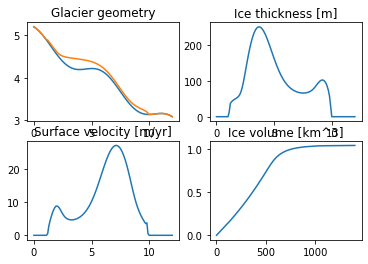

In [4]:
fig, axs = plt.subplots(2, 2)

axs[0,0].plot(x,b_spinup, label = "Basal topography")
axs[0,0].plot(x,h_spinup[:,-1], label = "Ice Surface")
axs[0,0].set_title("Glacier geometry")

axs[0,1].plot(x,1000*H_spinup[:,-1], label = "Ice thickness")
axs[0,1].set_title("Ice thickness [m]")

axs[1,0].plot(x,1000*vx_surface_spinup[:,-1], label = "Ice thickness")
axs[1,0].set_title("Surface velocity [m/yr]")

axs[1,1].plot(t,vol_spinup)
axs[1,1].set_title("Ice volume [km^3]")

## 50 years of actual simulation after spinup of a mountain glacier

Since we need a mountain glacier that has a reduced thickness over time, we change the source term from 
$$
M(x) = M_0 - x M_1 \:\text{(accumulation rate, essentially a source term)}\\
M_0 = 4.0 \:\text{m/yr}, \:M_1 = 0.0002 \:\text{yr}^{-1}\\
$$
to 
$$
M(x) = M_0 - x M_1 \:\text{(accumulation rate, essentially a source term)}\\
M_0 = 1.7 \:\text{m/yr}, \:M_1 = 0.0002 \:\text{yr}^{-1}\\
$$

This gives a realistic simulation with the thickness reducing by 1 m/yr in some regions.

In [ ]:
A = 1e-16
n = 3
rho = 920.0
g = 9.2 
dx = 0.5
dt = 1./48.

def accum_rate_func(x):
    M = 0.0017-0.0002*x
    return M

def simulation(h_init, L, T, accum_rate_func, basal_topology_func):



    nx = int(L/dx)
    nt = int(T/dt)
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    M = accum_rate_func(x)
    b = basal_topology_func(x,L)

    ### (1.e3)**n factor appears since we convert g from m/s^2 to km/s^2 
    C = 2*A/(n+2) * (rho*g)**n * (1.e3)**n

    print(f"True value of C = {C}")

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = np.copy(h_init)
    h[0,:] = b[0]
    h[-1,:] = b[-1]
    
    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
    
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]

        H[:,i] = h[:,i] - b
        
        

    alpha_sx = np.zeros((nx+1,nt+1))
    tau_d = np.zeros((nx+1,nt+1))
    alpha_sx[0, :] = (h[1, :] - h[0, :]) / dx
    alpha_sx[-1, :] = (h[-1, :] - h[-2, :]) / dx
    alpha_sx[1:-1, :] = (h[2:, :] - h[:-2, :]) / (2*dx)
    tau_d = - rho * g * H * alpha_sx
    phi = 0.0

    vx_surface = 2*A/(n+2) * (tau_d)**n * (1.e3)**n * H * (phi + 1)

    return x, t, H, h, b, vx_surface, alpha_sx, C, n

In [ ]:
L = 10.
T = 50.
h_init = h_spinup[:,-1]
x, t, H_true, h_true, b_true, vx_surface_true, alpha_sx_true, C_true, n_true = simulation(h_init, L, T, accum_rate_func, basal_topology_func)

In [ ]:
plt.plot(b_true, label = "Basal topography")
plt.plot(H_true[:,-1], label = "Ice thickness")
plt.plot(h_true[:,-1], label = "Ice Surface")
plt.plot(h_spinup[:,-1], label = "Ice surface after spinup")
plt.title("Actual solution, 50 years after spinup")
plt.xlabel("x-extent in km")
plt.ylabel("Height in km")
plt.legend()
plt.legend()

Ice thickness (as can be seen below), changes by about 1 metre/yr in some regions for these 50 years.

In [ ]:
plt.plot((-h_true[:,-1]+h_spinup[:,-1])*1000/T, label = 'Thickness reduction in m/yr')
plt.xlabel("x-extent in km")
plt.ylabel("Height in km")
plt.legend()